!pip install numpy, pandas, networkx, matplotlib, seaborn

In [51]:
import random
import numpy as np
import pandas as pd
import networkx as nx
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
def create_intimacyMatrix(
    rng,
    population,
    size=None,
    intra_strength=0.6,  # within
    inter_strength=0.2,  # between
    min_weight=0.01,
):
    """
    Create an asymmetric, row-normalized intimacy matrix for two communities.

    Parameters:
        rng : int
            Seed for reproducibility.
        population : int
            Number of agents (make sure to subtract 1 if using raw population for leader exclusion).
        size : tuple(int,int) or None
            Sizes of the two communities. If None, split roughly equally.
        intra_strength : float
            Upper bound for intra-community weights (0...1) -- within communities.
        inter_strength : float
            Upper bound for inter-community weights (0...1) -- between communities.
        min_weight : float
            The smallest weight allowed for any pair. Must be > 0; we want no zeros.

    Returns:
        intimacyMatrix : ndarray, shape (population, population)
            Row-normalized intimacy matrix with values in (0,1], no zeros.
        assignments : ndarray, shape (population,)
            Community assignment (0 or 1) for each agent. (b/c 0/1 are used for indexing later on)
    """
    assert population % 2 == 0, "We're not working with odd populations here. Check the population value passed."

    if size is None:  # if no size is given
        n1 = population // 2
        n2 = population - n1
    else:
        n1, n2 = size
        assert n1 + n2 == population, "size must sum to population."  # if you're gonna give a size, it has to make sense

    assert 0 <= intra_strength <= 1 and 0 <= inter_strength <= 1  # strengths must be within [0,1]
    assert min_weight > 0 and min_weight < 1  # let the weights be within (0,1)

    # Assignment array: first n1 agents are in community 0, next n2 agents are in community 1
    assignments = np.array([0]*n1 + [1]*n2)

    # Block upper bounds (strongest intimacy allowed): diagonal = intra = within, off-diagonal = inter = between  (like the preference matrix execpt that the values represent the maximum allowed intimacy between a pair)
    block_bounds = np.array([[intra_strength, inter_strength],
                             [inter_strength, intra_strength]])

    # Asymmetric weights per ordered pair (i -> j)
    W = np.zeros((population, population), dtype=float)  # create a square matrix of zeros of the population size
    for i in range(population):
        for j in range(population):
            bound = block_bounds[assignments[i], assignments[j]]  # intimacy upper bound depending on the communities in which each agent belongs to
            
            assert bound >= min_weight, "min_weight exceeds the upper bound set for a pair of agents. You must revise min_weight, intra_strength, or inter_strength."
            
            w = rng.uniform(min_weight, bound)  # otherwise, pick a random value between the min_weight and high
            W[i, j] = w  # assign value to be the intimacy from i to j

    # Normalize so each row sums to 1 (interpretable as outgoing probabilities)
    row_sums = W.sum(axis=1, keepdims=True)
    intimacyMatrix = W / row_sums

    return intimacyMatrix, assignments  # assignments is a 1D array where each element i corresponds to each agent index i and tells us which community that agent was assigned to which we can use for community stuff later if desired (like visuals or maybe other stuff)


In [72]:
#Initialization
def initialize(rng):
    '''
    Initialization function of simulation environment -- setup the variables.
    (D) = dynamic parameter (continuously updated) and (S) = static parameter (fixed)
    The intervals used have a uniform/gaussian distribution.
    Agent parameters:
        emotion (D): How an agent feels towards the change. Defined within the interval [-0.5, 0.5] following a beta distribution to skew towards the negative side -- a shifted [0,1].
                     The purpose behind the interval is because we want to see how a leaders emotional aperature dictates the evolution of the emotion contagion which gives more meaningful results when emotions initially tend more negative (encourages the random number picker towards negative).
        expressiveness (S): The degree to which an agent would display their emotion. [0,1]
        delta (S): Susceptibility to being influenced. This can also be thought of as how resistant an agent may be (stubborness, strong-headedness, etc.)
        amplification (D): How much an agent's emotion is amplified when interacting with another agent. This is a combination of other parameters
        bias (D): How much an agent's emotion is biased towards similar emotions. This is a combination of other parameters
    Leader parameters:
        emotion (S): Value = 1. We assume the leader is completely on board (feels fully positive) about the change.
        charisma (S): leaders ability to influence the team. This is a value between 0 and 0.5, arbitrarily chosen by us
        emotionManagementAbility (S): leaders ability to manage the sentiments amongst the team [H,L]. H = high ability, L = low ability
        interventionThreshold (S): what the average sentiment amongst the team needs to be in order for the leader to intervene 
    Other:
        intimacyMatrix (S): Represents agent-to-agent relationships (how close they are to each other) [0,1]. Explicitly indicates probability of an interaction between a pair of agents (one-way intitiation). 
                            Leader is currently excluded from the assigment of intimacy between it and it's team members.
                            Intimacies are asymmetrical amongst agent pairs (i.e. how close agentA feels to agentB and how close agentB feels to agentA need not be the same).
    '''
    global agents, leader, intimacyMatrix, assignments # create global variables so that they are readily accessible outside of this function (on the basis that this function is called before the variables within are needed to be used elsewhere)

    agents = []  # initialize list of agents -- simple and dynamic data structure, e.g. lists can change in size (meaning agents added or removed during simulation -- though we are not doing this); order is preservered, thus ensuring agents are consistently/simply iterated over
    for _ in range(populationSize):  # for each agent in the population
        newAgent = {
            'emotion': -0.5 + 1 * rng.beta(2, 5), 
            'delta': rng.uniform(0, 1),
            'expressiveness': rng.uniform(0,1),
            'amplification': rng.uniform(0,1),
            'bias': rng.uniform(0,1)
            }  # dictionary for parameter readability
        agents.append(newAgent)  # add agent to list
    

    leader = rng.choice(agents)  # randomly select an agent from the list to designate as leader 
    agents.remove(leader)  # remove it from the agents list as they will behave differently and their parameters are going to be changed below
    

    ### Update leader parameters
    del leader['delta']  # remove this and below as they are not needed for the leader
    del leader['expressiveness']
    del leader['amplification']
    del leader['bias']

    leader['emotion'] = 1  # fix leader emotion
    
    
    # Add parameters
    if style == 'High_Aperture':
        leader.update({'emotionManagementAbility': 'High'})
        leader.update({'interventionThreshold': -0.5})  # we're only playing around with this aspect of leader aperture, so we only vary this parameter
    elif style == 'Low_Aperture':
        leader.update({'emotionManagementAbility)': 'Low'})
        leader.update({'interventionThreshold': -0.7})

    ### Leader-agent weights -- future consideration
    # leaderAgentWeights = rng(rng.uniform(0,1), (populationSize-1, 1))

    # Assign an index to each agent for easy access later on -- this allows to have a one-to-one mapping between the agents list and intimacy matrix indices
    for idx, agent in enumerate(agents):
        agent['index'] = idx  

    ### Intimacy weights (agent-wise)
    intimacyMatrix, assignments = create_intimacyMatrix(rng=rng, population=populationSize-1)

In [73]:
def emotional_valence_update(agentA, agentB, agentA_index, agentB_index):  # are the matrix and dictionary indices aligning?
    '''
    For updating the emotional valence of each agent when they interact with the other agents.
    For contagionStrength, one may also think of it as influence strength
    '''
    # Initialize the absolute difference dictionary if the pair is not already in there
    if (agentB_index, agentA_index) not in absorption_dict:  # if the pair has not been seen before, initialize it
        absorption_dict[(agentB_index, agentA_index)] = 0
    if (agentA_index, agentB_index) not in absorption_dict:
        absorption_dict[(agentA_index, agentB_index)] = 0    
    
    # Lets set up the variables for the Bosse et al. (2015) model
    initial_qA = agentA['emotion']  # emotion before update
    initial_qB = agentB['emotion']

    # Recall this is the contagion strength parameter. The higher/stronger the value, the higher the contagion and thus faster convergence
    gamma_A = sum(sender['expressiveness']*intimacyMatrix[sender['index'], agentA['index']]*agentA['delta'] for sender in agents if sender != agentA)
    gamma_B = sum(sender['expressiveness']*intimacyMatrix[sender['index'], agentB['index']]*agentB['delta'] for sender in agents if sender != agentB)

    eta_A = agentA['amplification']
    eta_B = agentB['amplification']

    beta_A = agentA['bias']
    beta_B = agentB['bias']

    groupEmos_A = sum(cat['expressiveness']*intimacyMatrix[cat['index'], agentA['index']] for cat in agents if cat != agentA)  # this is w, the weighted sum of all agents' expressiveness
    qstar_A = sum(
        ((sender['expressiveness']*intimacyMatrix[sender['index'], agentA['index']]) / groupEmos_A)*sender['emotion'] for sender in agents if sender != agentA
        )
    
    groupEmos_B = sum(cat['expressiveness']*intimacyMatrix[cat['index'], agentB['index']] for cat in agents if cat != agentB)
    qstar_B = sum(
        ((sender['expressiveness']*intimacyMatrix[sender['index'], agentB['index']]) / groupEmos_B)*sender['emotion'] for sender in agents if sender != agentB
        )

    PI_A = 1 - (1 - qstar_A)*(1 - initial_qA)
    NI_A = qstar_A*initial_qA

    PI_B = 1 - (1 - qstar_B)*(1 - initial_qB)
    NI_B = qstar_B*initial_qB

    
    agentA['emotion'] += gamma_A*(eta_A*(beta_A*PI_A + (1-beta_A)*NI_A) + (1 - eta_A)*qstar_A - initial_qA)
    agentA['emotion'] = np.clip(agentA['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]      
    absorption_dict[(agentB_index, agentA_index)] += abs(initial_qA - agentA['emotion'])


    agentB['emotion'] += gamma_B*(eta_B*(beta_B*PI_B + (1-beta_B)*NI_B) + (1 - eta_B)*qstar_B - initial_qB)
    agentB['emotion'] = np.clip(agentB['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]
    absorption_dict[(agentA_index, agentB_index)] += abs(initial_qB - agentB['emotion'])

In [74]:
def avgEmotion(agents):
    '''
    Calculate average emotion valence amongst the team.
    '''
    return (sum(agent['emotion'] for agent in agents))/len(agents)

In [75]:
def agent_interaction(rng): 
    '''
    Define inter-agent interactions. 
    Since their intimacy is defined using a probabilty, we say if that is a above a randomly generated number in [0,1], that is an interaction.
    '''
    global agents, emotion_history, avg_emotion_history

    buddies = []
    for i, agentA in enumerate(agents):  # for each index i and the agent, agentA, at that index in agents list (NOTE: using enumerate() allows us to easily get the indices in the agents list which we later use to access the agent objects)
        for j, agentB in enumerate(agents):  # same as above but we use a different letter to help differentiate from above because
            if (i != j):  # we of course do not want to select the same agent haha
                interaction_prob = max(intimacyMatrix[int(i),int(j)], intimacyMatrix[int(j),int(i)])  #  get the intimacy of the agent with the stronger intimacy
                if (rng.random() < interaction_prob) and not ((i,j) in buddies or (j,i) in buddies):  # if that intimacy is greater than some random number and that pair of agents is not already in the buddies list (to avoid double counting unless we decide how to explain what that means)
                    buddies.append((i,j))  # we shall define this as an interaction

    for i,j in buddies:  # for each pair i,j in our buddies list
        agentA, agentB = agents[i], agents[j]  # get the corresponding agent objects
        emotional_valence_update(agentA, agentB, i, j)  # update the emotional valence of both

    return buddies

In [76]:
def leader_intervention():
    '''
    Here we define when a leader intervenes and what happens when they do (update the Emotion of agents). 
    We use a leaderImpact value to specify the degree of their intervention. This is currently some arbitrary value greater than 0.
    We do not have to specify what the intervention is, just the degree that it impacts the team and here we may get creative.
    '''
    dampening = 0.06  # a factor so the leader intervention doesn't cause such large spikes in emotions
    if avg_emotional_valence <= leader['interventionThreshold']:  # leader intervenes when the average emotion is at that leaders minimum intervention threshold level
        for agent in agents:
            agent['emotion'] += dampening*(leader['emotion'] - agent['emotion'])*agent['delta']  # multiplying by an agents susceptibility makes the intervention impact vary per agent
            agent['emotion'] = np.clip(agent['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]

In [77]:
def sentiment_evolution_graph(intervention_timesteps, run_id):
    '''
    A graph to show the evolution of all emotions throughout the time steps (essentially a time series!). That is, the emotions from start to end.
    NOTE: mark when leader intervenes (x-axis)
    '''
    emotion_array = np.array(emotion_history)  # shape: (timesteps, num_agents)
    avg_array = np.array(avg_emotion_history)
    number_of_agents = emotion_array.shape[1]
    flat_interventions = sorted(set(intervention_timesteps))  # flatten the list of lists and sort it

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(number_of_agents):
        ax.plot(emotion_array[:, i], alpha=0.6, color='gray')
        # cmap = plt.get_cmap('tab10')  # Use a colormap for distinguishable colors
        # ax.plot(emotion_array[:, i], alpha=0.6, color=cmap(i % cmap.N))  # Assign a unique color to each agent

    for t in flat_interventions:
        ax.axvline(x=t, color='tab:blue', linestyle='--', alpha=0.5, label='Leader Intervention' if t == flat_interventions[0] else "") # mark the intervention times with a vertical line

    ax.plot(avg_array, color='red', linewidth=2, label='Average Emotion')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Emotion Value')
    ax.set_title(f'Sentiment Dynamics Over Time\n{style}, Simulation {run_id}')
    ax.grid(True)
    ax.set_ylim(-1, 1)
    ax.legend()
    plt.close()

    return fig

In [78]:
def social_network_graph(buddies_per_timestep, absorption_dict):
    '''
    To create a social network graph representing the agent interactions throughout the simulation.
    Idea 1 (undirected): edges between agents represent how frequently that pair interacted (intensity=frequency) and hopefully which agents were the most influential/popular
    Idea 2 (directed): two edges maximum allowed between agents (one in each direction) representing the exchange of information from one agent to the other
    '''
    from collections import Counter
    flat_buddies_per_timestep = [item for sublist in buddies_per_timestep for item in sublist]  # flatten the list of lists

    # 1) interaction frequency graph
    G = nx.Graph()  # create a new graph object
    G.add_nodes_from([agent['index'] for agent in agents])  # adding nodes where each represents an agent via it's index in the agents list
    edge_weights_dict = Counter(flat_buddies_per_timestep)  # count the frequency of each interaction
    G.add_weighted_edges_from([(i, j, weight) for (i,j), weight in edge_weights_dict.items()])


    # 2) information exchange graph
    DG = nx.DiGraph()
    DG.add_nodes_from(G)  # want the same nodes, just different edges
    DG.add_weighted_edges_from([(i, j, weight) for (i, j), weight in absorption_dict.items()])  # only add edges where there was a change in emotion valence

    return G, DG

In [79]:
def run_simulation(seed, run_id):
    '''
    Calling all functions as necessary and storing the results and associated parameters
    '''
    global time, emotion_history, avg_emotion_history, avg_emotional_valence, absorption_dict
    
    rng = np.random.default_rng(seed)  # seed for reproducibility
    initialize(rng)  # set up environment
    characteristics = ['emotion', 'delta', 'expressiveness', 'amplification', 'bias']
    initial_conditions = pd.DataFrame([{k: agent[k] for k in characteristics} for agent in agents])

    emotion_history = []  # to store the emotions of each agent at each time step (for sentiment evolution graph and sentiment segregation visual)
    emotion_history.append([agent['emotion'] for agent in agents])  # add each agent's emotion to this list for tracking over time -- doing it here will get us their initial states (before agent interaction or leader intervention)
    avg_emotion_history = []  # to store the average emotion of the agents at each time step (for sentiment evolution graph)
    buddies_per_timestep = []  # to store the buddies (interactions) at each time step
    interactions_per_timestep = [] # to store the number of interactions per time step
    intervention_timesteps = []  # to store the time steps at which the leader intervenes
    absorption_dict = {}  # dictionary to store the absolute difference in emotion valence between agent pairs (key: (agentA_index, agentB_index), value: absolute difference) to indicate how much they've absorbed
    
    
    time = 0
    while time < max_iterations:  # while both conditions of convergence not reached and the max iterations is also not reached, the simulation continues (when at least one of the conditions is met, then it will stop)
        buddies = agent_interaction(rng)
        buddies_per_timestep.append(buddies)  # store the interactions at this time step
        interactions_per_timestep.append(len(buddies))  # store the number of interactions at this time step
        avg_emotional_valence = avgEmotion(agents)
        avg_emotion_history.append(avg_emotional_valence)


        # If the avg emotion valence falls within the leaders intervention threshold
        if style != "No_Intervention" and avg_emotional_valence <= leader['interventionThreshold']:
            leader_intervention()
            intervention_timesteps.append(time)

        emotion_history.append([agent['emotion'] for agent in agents])  # doing it here will get us their emotions as the simulation continues
        time += 1

    networkG, networkDG = social_network_graph(buddies_per_timestep, absorption_dict)  # create the social network graph at the end of the simulation to show the interactions
    sentiment = sentiment_evolution_graph(intervention_timesteps, run_id)  # create time graph at end of simulation to show the evolution

    leader_data = {
        'emotionManagementAbility': leader.get('emotionManagementAbility'),
        'interventionThreshold': leader.get('interventionThreshold'),
        'final_avg_emotion': avg_emotion_history[-1] if avg_emotion_history else None,
        'final_agent_emotions': [agent['emotion'] for agent in agents],
    }

    results = {
        'leader_data': leader_data,
        'emotion_history': emotion_history,
        'avg_emotion_history': avg_emotion_history,
        'intervention_timesteps': intervention_timesteps,
        'final_avg_emotion': avg_emotional_valence,
        'network_graph': networkG,
        'network_digraph': networkDG,
        'absorption_dict': absorption_dict,
        'initial_conditions': initial_conditions,
        'sentiment_graph': sentiment,
        'intimacy_matrix': intimacyMatrix
    }
    
    return results

In [80]:
from dataclasses import dataclass

@dataclass
class AllSimulationResults:
    emotion_histories: list
    avg_emotions: list
    interventions: list
    G_networks: list
    DG_networks: list
    absorption_dicts: list
    initial_conditions: list
    sentiment_graphs: list
    intimacy_matrices: list

In [81]:
def run_multiple_simulations(runs):
    '''
    Run multiple simulations
    '''
    all_emotion_histories = []
    all_avg_emotion = []
    all_interventions = []
    all_G_networks = []
    all_DG_networks = []
    all_absorption_dicts = []
    all_initial_conditions = []
    all_sentiment_graphs = []
    all_intimacy_matrices = []
    for run in range(runs):
        global agents, leader, emotion_history, avg_emotion_history  # reset the global variables for each run

        leader = {'emotion': 1, 'emotionManagementAbility': style, 'interventionThreshold': -0.2}
        results = run_simulation(seed=run, run_id=run)  # run the simulation with a different seed for each run
        all_emotion_histories.append(results['emotion_history'])
        all_avg_emotion.append(results['avg_emotion_history'])
        all_interventions.append(results['intervention_timesteps'])
        all_G_networks.append(results['network_graph'])
        all_DG_networks.append(results['network_digraph'])
        all_absorption_dicts.append(results['absorption_dict'])
        all_initial_conditions.append(results['initial_conditions'])
        all_sentiment_graphs.append(results['sentiment_graph'])
        all_intimacy_matrices.append(results['intimacy_matrix'])

    return AllSimulationResults(
        emotion_histories=all_emotion_histories,
        avg_emotions=all_avg_emotion,
        interventions=all_interventions,
        G_networks=all_G_networks,
        DG_networks=all_DG_networks,
        absorption_dicts=all_absorption_dicts,
        initial_conditions=all_initial_conditions,
        sentiment_graphs=all_sentiment_graphs,
        intimacy_matrices=all_intimacy_matrices
    )

In [96]:
# All functions get executed here

# Make sure to keep populationSize odd because the leader gets taken out and the team gets evenly divided for the intimacy matrix (not literally, it's just to help create a network structure) (evenly doesn't really matter, and i'm sure you can add code to account for that--it'd just be more complexity and for what>)
populationSize = 15  # Bosse et al. (2015) used 10 agents, so we keep ours around that size for small team representation, while still trying to introduce a little more variety
style = "Low_Aperture"  # designate "High_Aperture", "Low_Aperture", or "No_Intervention" to indicate the leaders emotion management ability
runs = 14
max_iterations = 260

all_results = run_multiple_simulations(runs=runs)

In [ ]:
# # Let's pickle everything (saving in a python readable format for simple reading into python)
import os
import pickle
from pathlib import Path


# Create heatmaps for visualizing the initial agent characteristics
heatmaps = []
for i, df in enumerate(all_results.initial_conditions):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.round(3), annot=True, cmap="coolwarm")
    plt.title(f"Heatmap of Initial Agent Parameters\n{style}, Simulation {i}")
    heatmaps.append(plt.gcf())  # get current figure and store it
    plt.close()

# # Folder and hierarchy set up
# todaysDate = date.today().strftime("%m_%d_%Y")
# #parentfolder = r"R:\sescott1\Masters\523\Simulation\Network\Bipartite"  # main folder under which you want the results to go
# parentfolder = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite"

# datefolder = Path(parentfolder)/todaysDate  # make the date folder
# # counter = 1
# # while os.path.exists(datefolder):
# #     datefolder = os.path.join(stylefolder, f"{todaysDate}_{counter}")
# #     counter += 1
# datefolder.mkdir(parents=True, exist_ok=True)

# stylefolder = Path(datefolder)/f"{style}"  # make the style folder under the date folder
# stylefolder.mkdir(parents=True, exist_ok=True)
# os.makedirs(stylefolder, exist_ok=True)

# results_folder = os.path.join(stylefolder)  # put it all together
# os.makedirs(results_folder, exist_ok=True)

# # Save all_results as one pickle
# all_results_path = os.path.join(results_folder, "all_results.pkl")
# with open(all_results_path, "wb") as f:
#     pickle.dump(all_results, f)

# # Save heatmaps separately, but you can also just recreate them in the other notebook too
# heatmaps_path = os.path.join(results_folder, "initial_conditions_heatmaps.pkl")
# with open(heatmaps_path, "wb") as f:
#     pickle.dump(heatmaps, f)

# print(f"✅ All results pickled under {results_folder}")

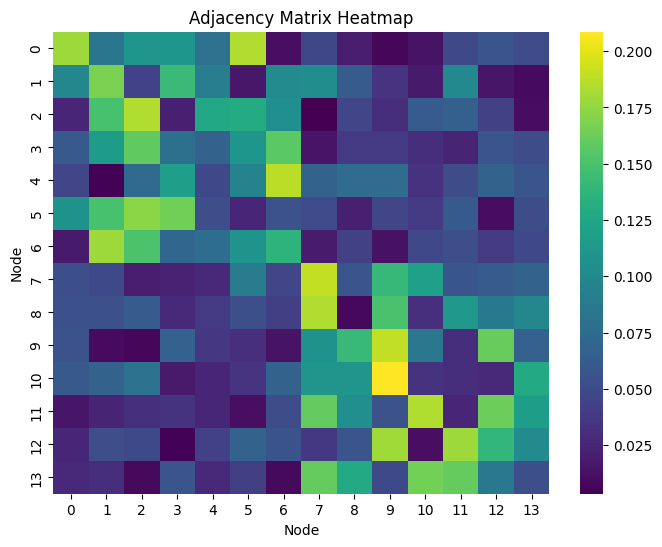

In [93]:
plt.figure(figsize=(8, 6)) 
sns.heatmap(intimacyMatrix, annot=False, cmap="viridis") 
plt.title("Adjacency Matrix Heatmap") 
plt.xlabel("Node") 
plt.ylabel("Node") 
plt.show()

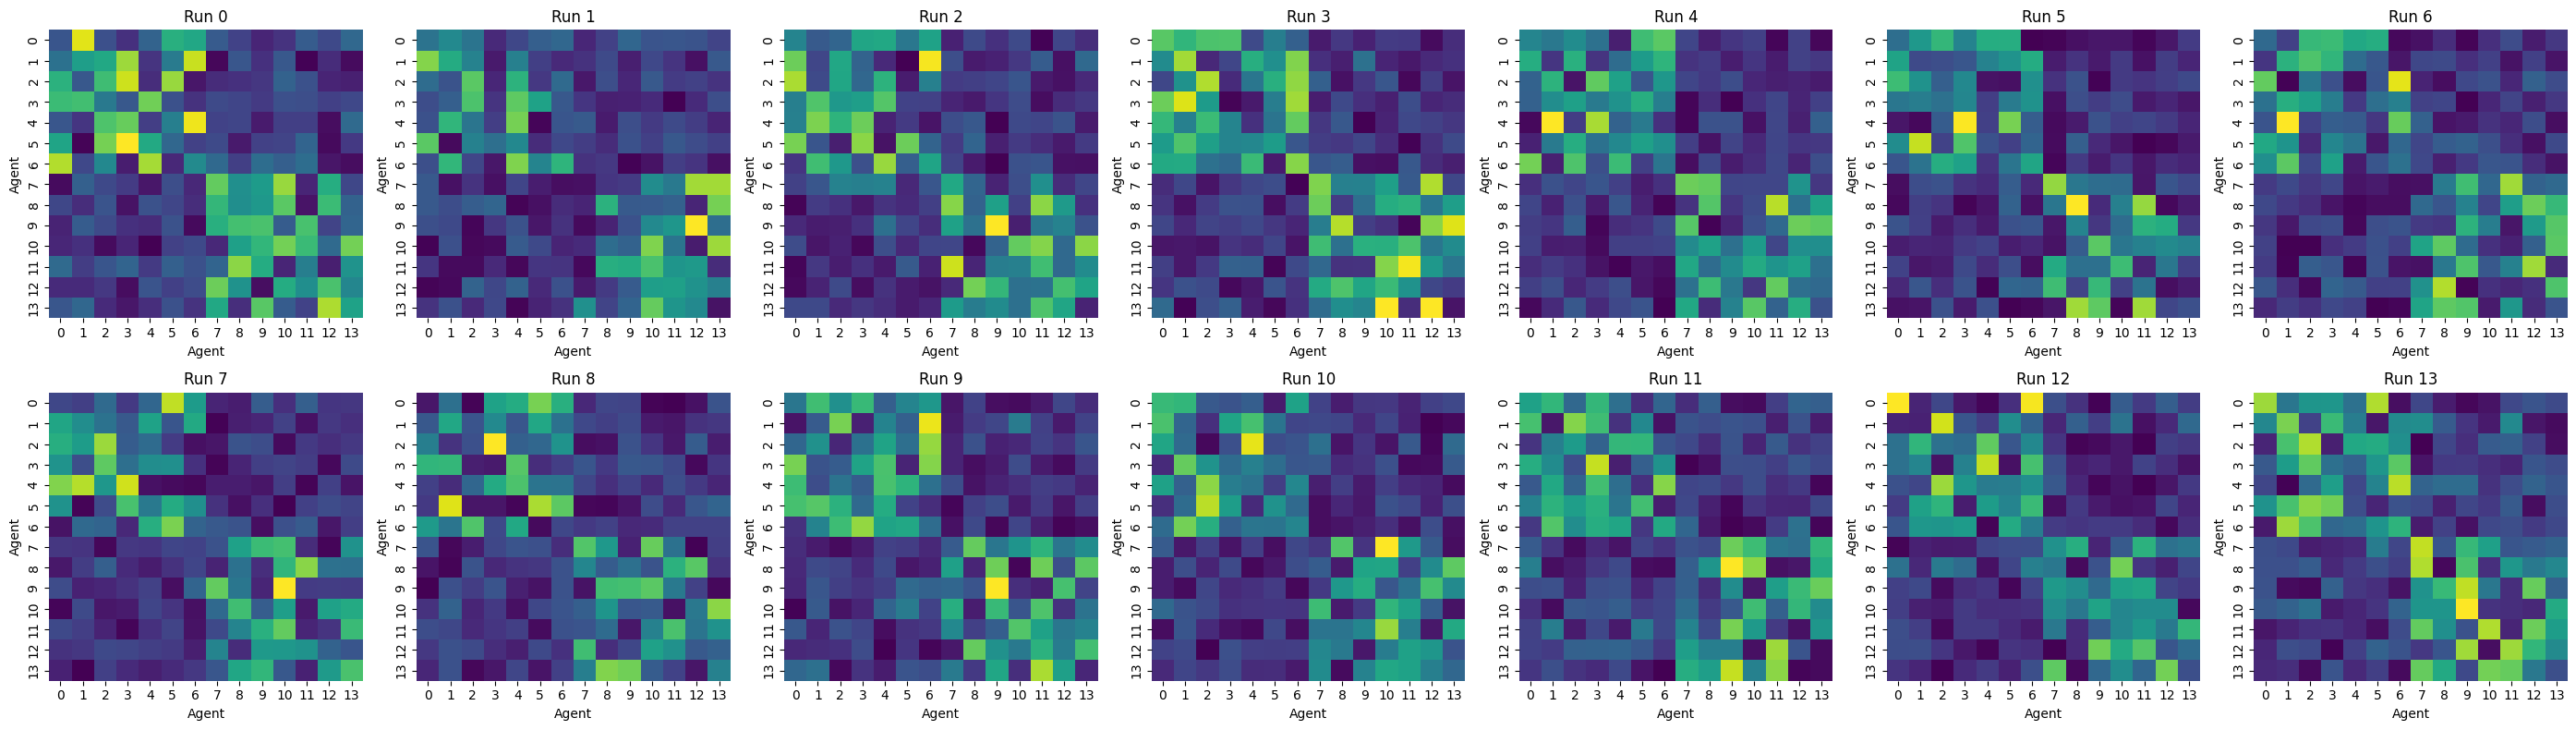

In [ ]:
matrices = all_results.intimacy_matrices
n = len(matrices)

fig, axes = plt.subplots(2, 7, figsize=(28, 8))  # grid size
axes = axes.flatten()  # flatten to easily iterate over

for i, matrix in enumerate(matrices):
    sns.heatmap(matrix, cmap="viridis", cbar=False, ax=axes[i])  # verbally describe the color bar scale in the figure discription caption thing in the paper
    axes[i].set_title(f"Run {i}")
    axes[i].set_xlabel("Agent")
    axes[i].set_ylabel("Agent")

for j in range(i+1, len(axes)):
    axes[j].axis("off")  # hide any unused subplots

plt.tight_layout()
plt.show()

Above we can see the different intimacy matrices for each run (it will be the same across leader types since the same seeds are being used to create each one across leader types). So the community structure varies slightly/somewhat run to run.

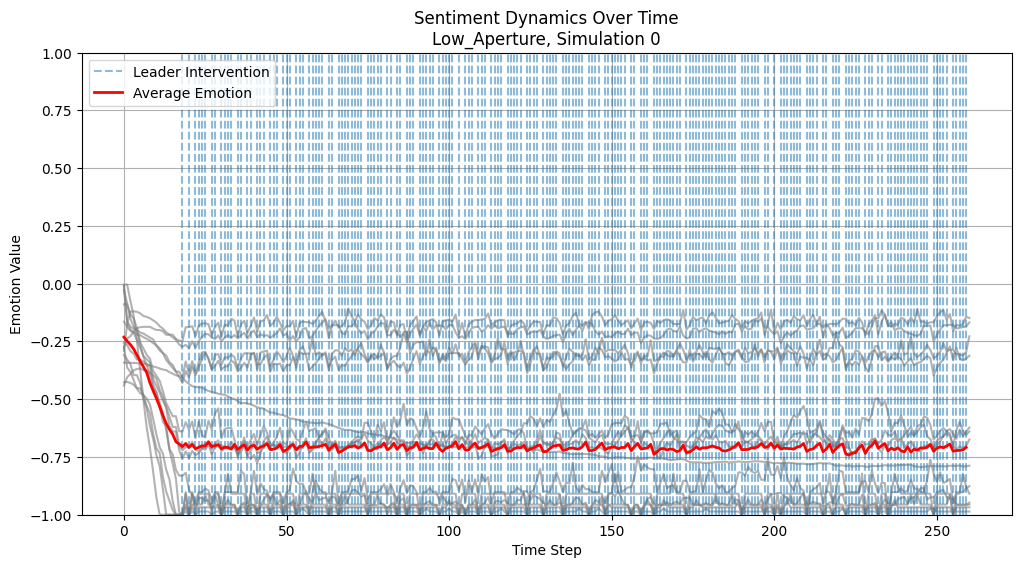

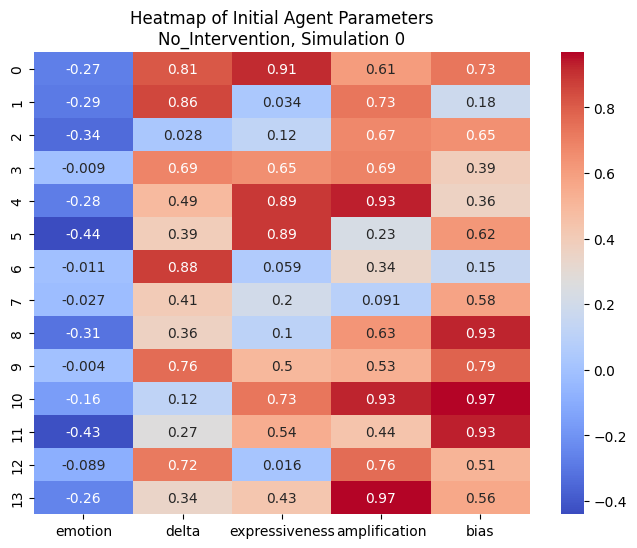

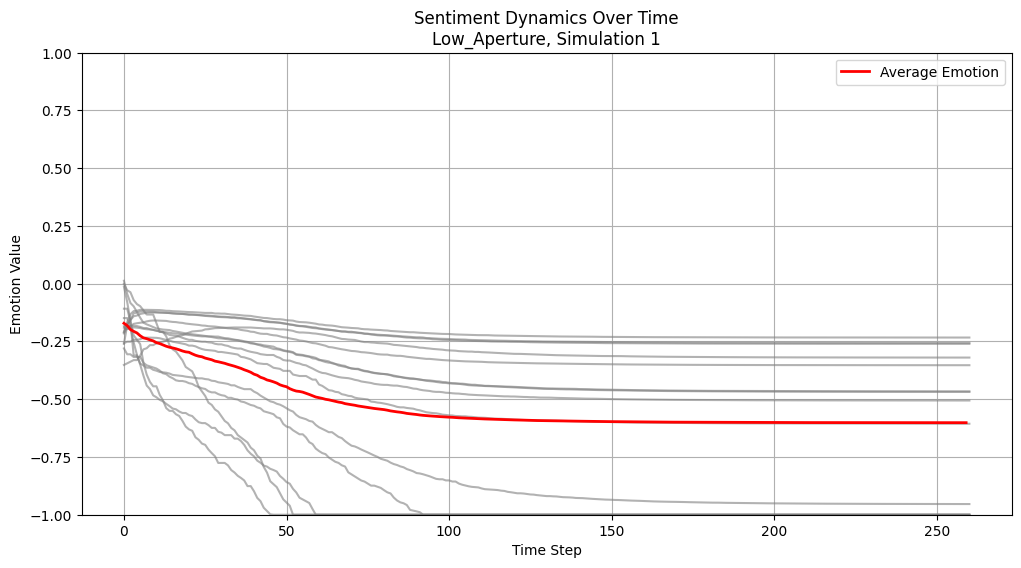

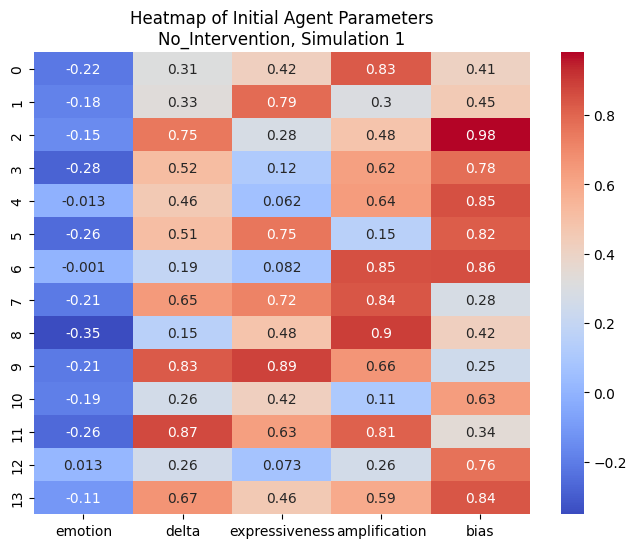

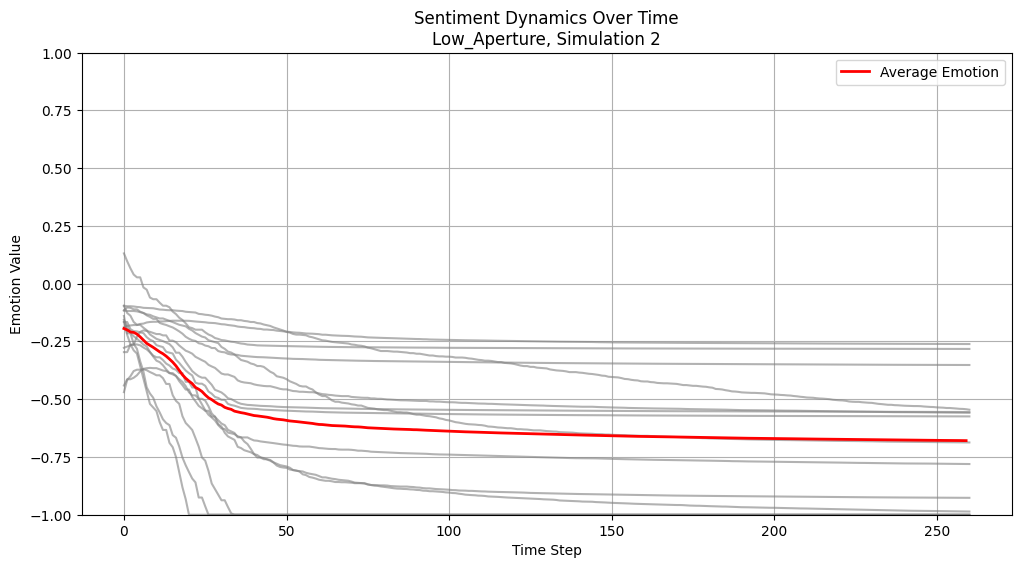

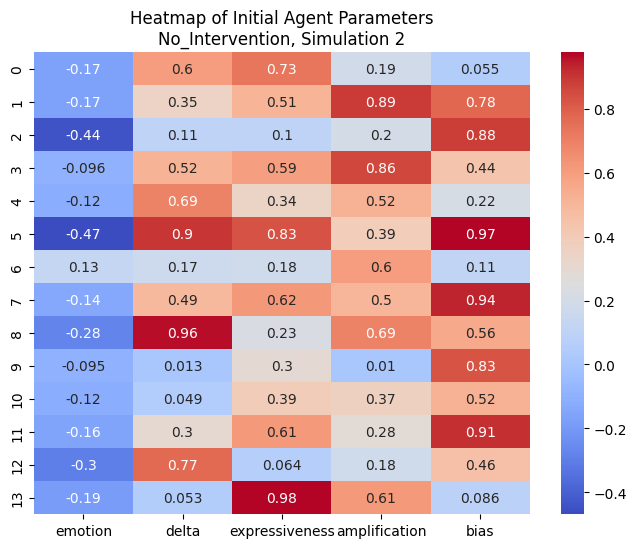

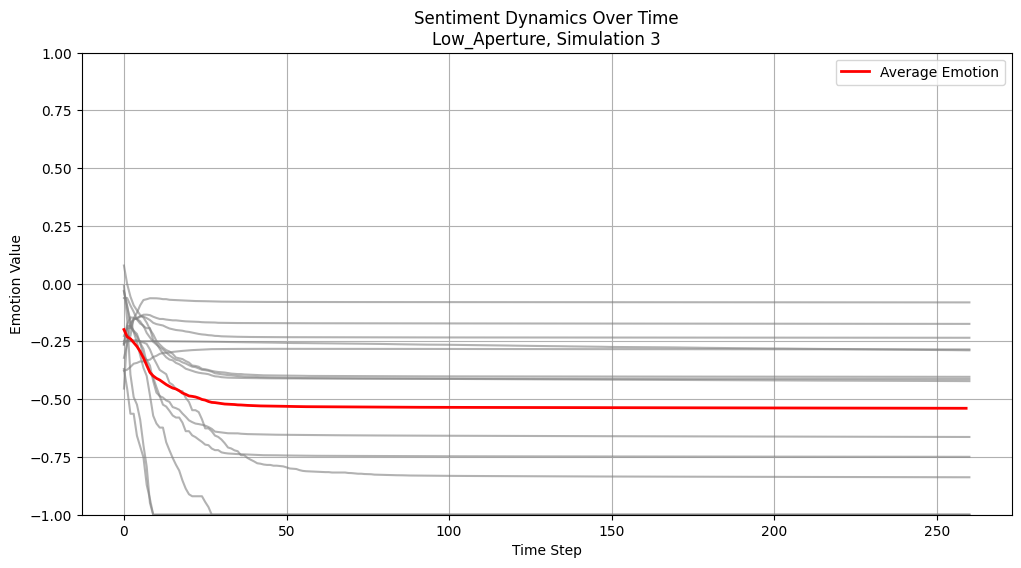

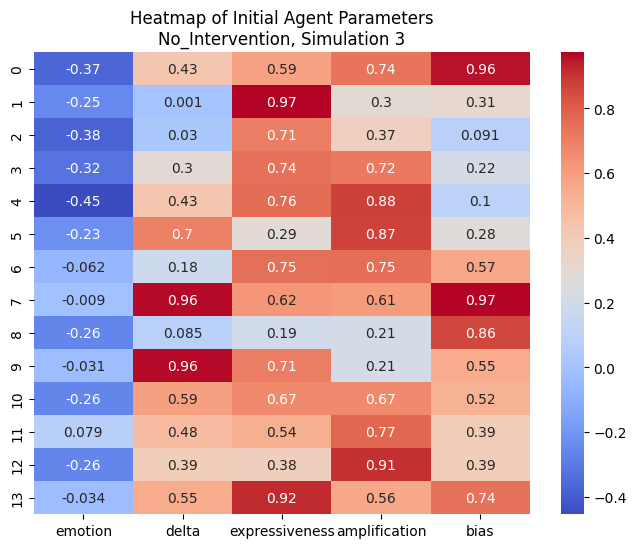

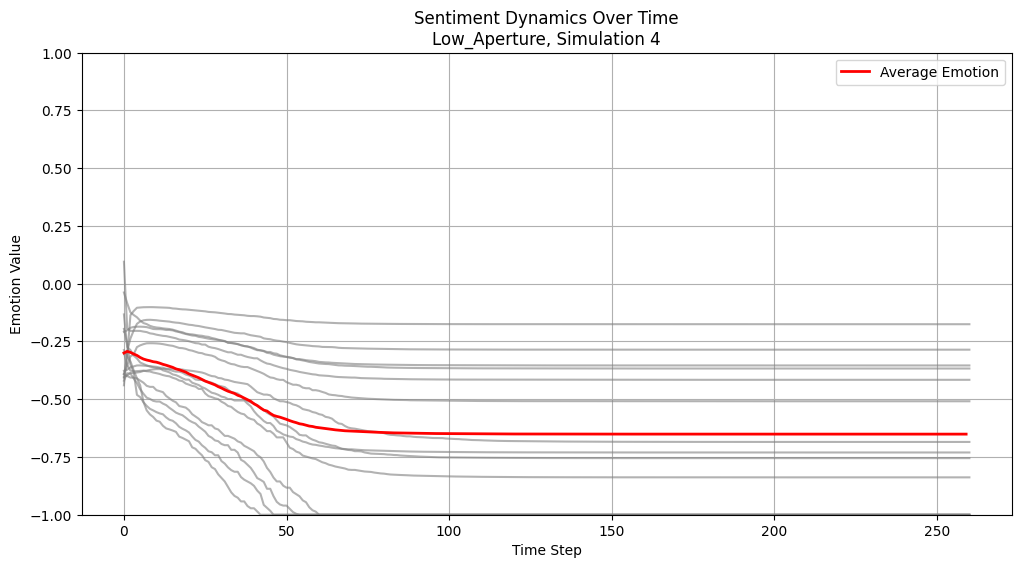

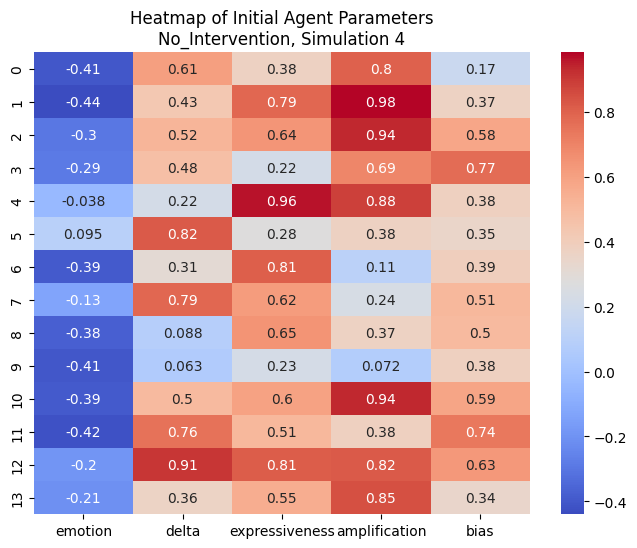

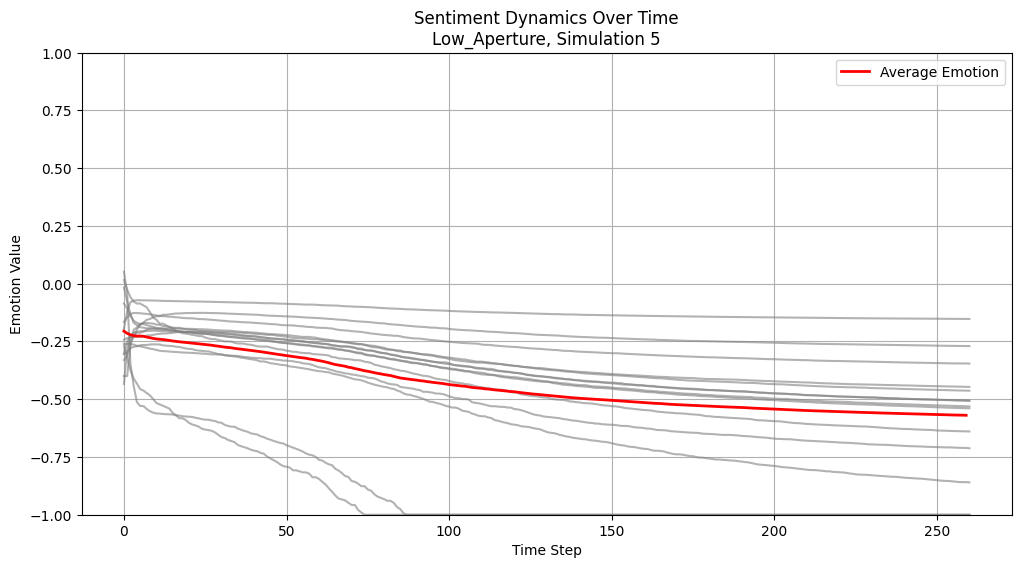

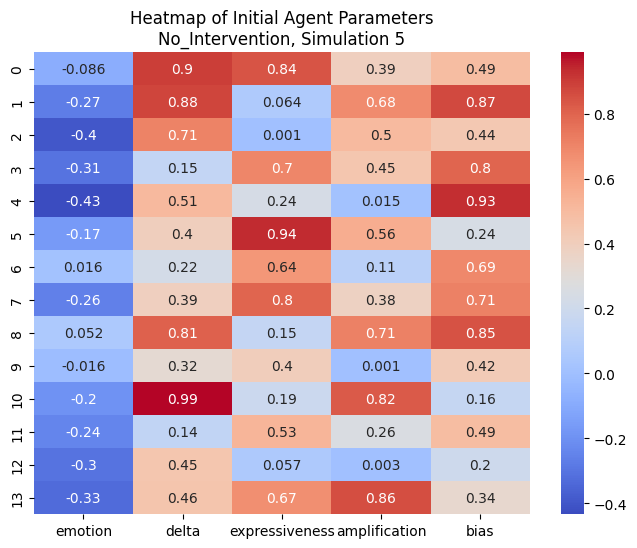

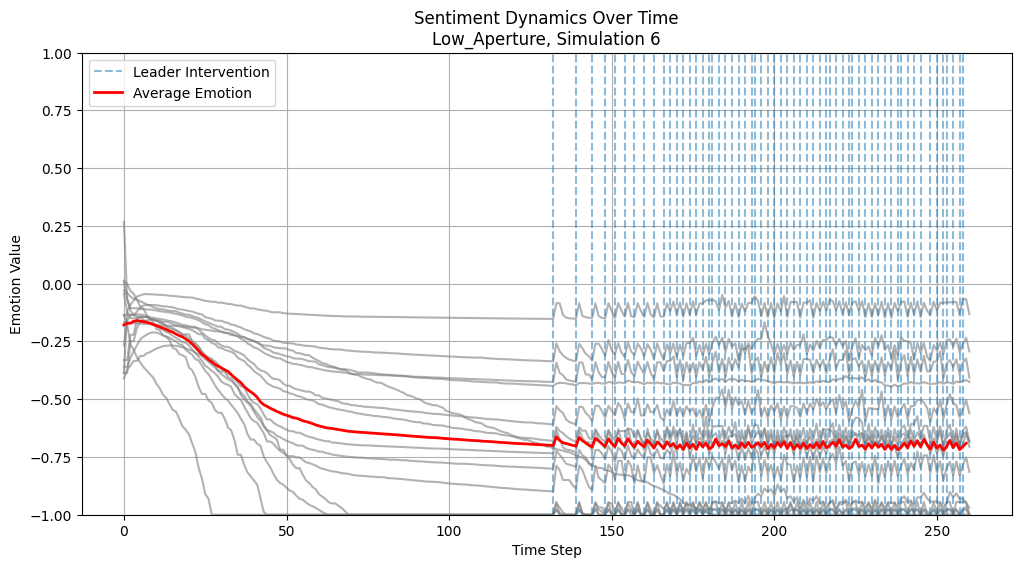

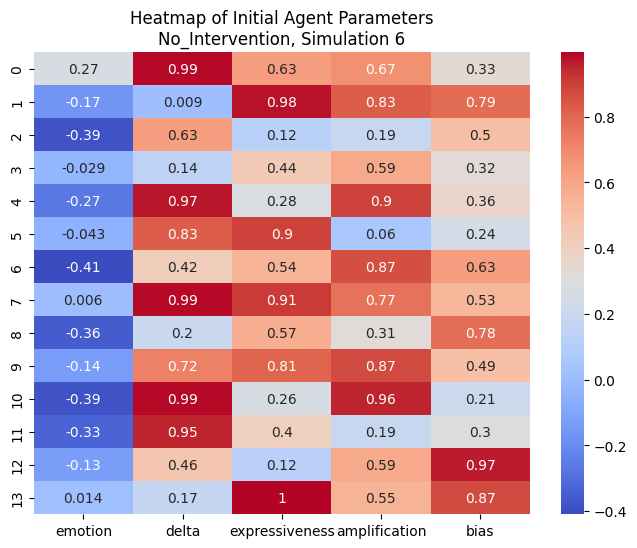

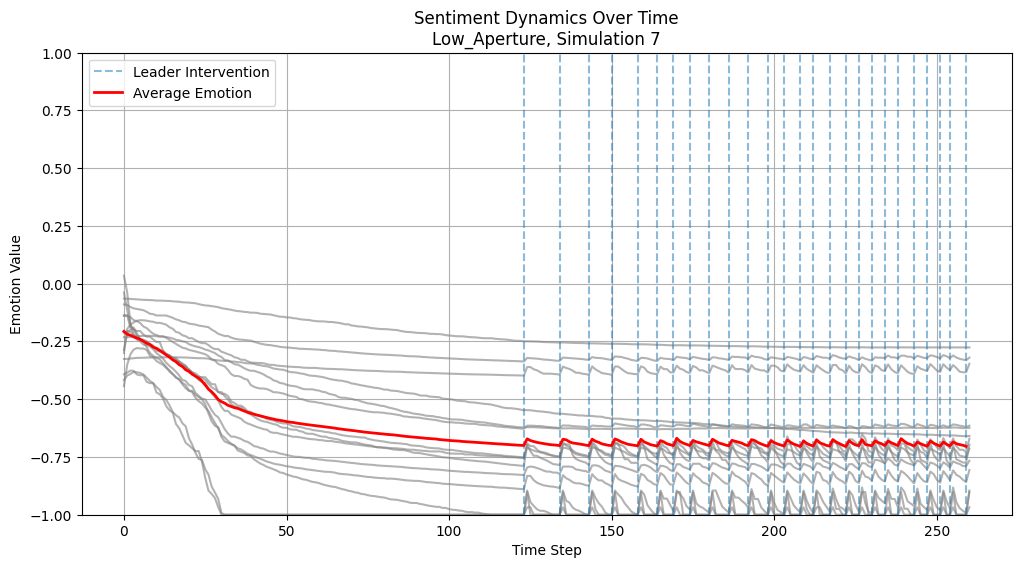

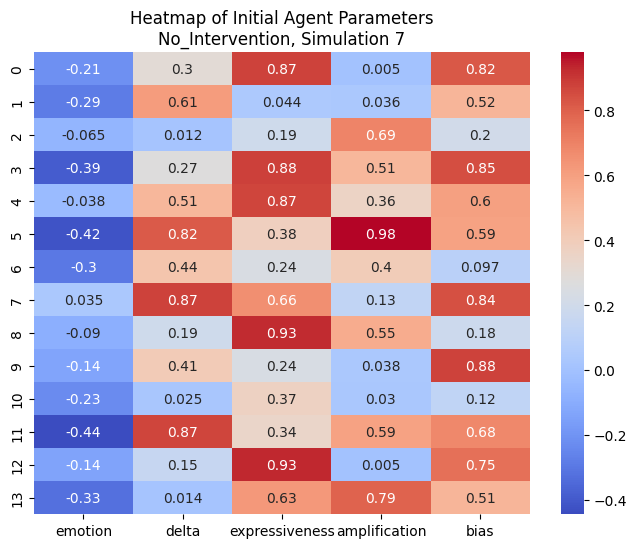

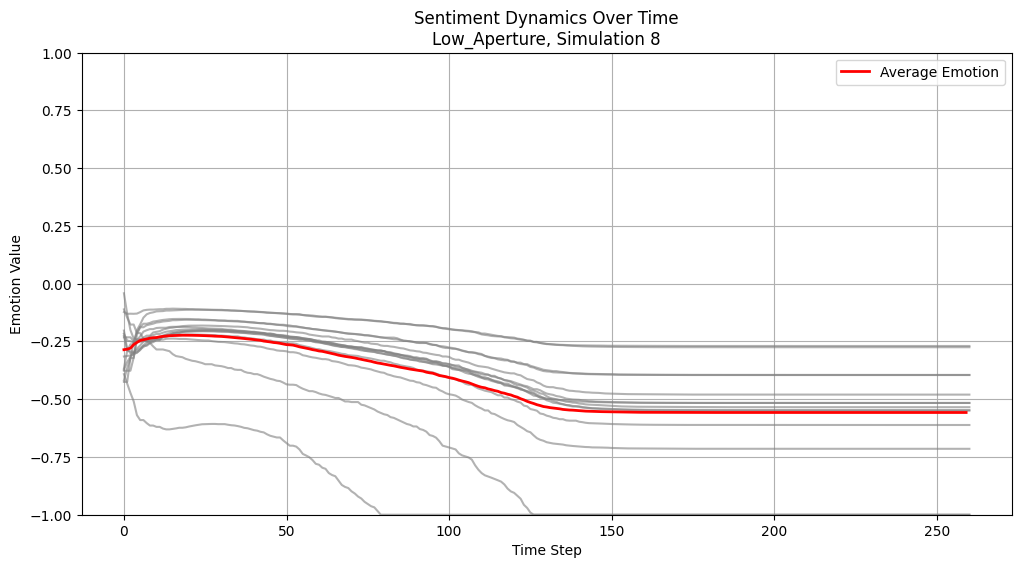

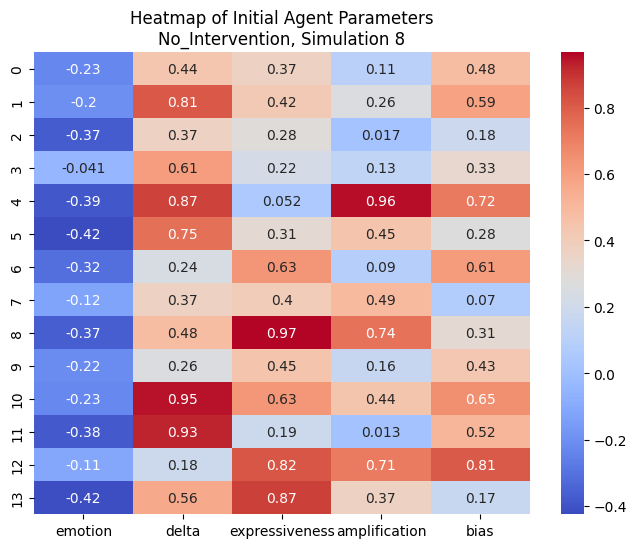

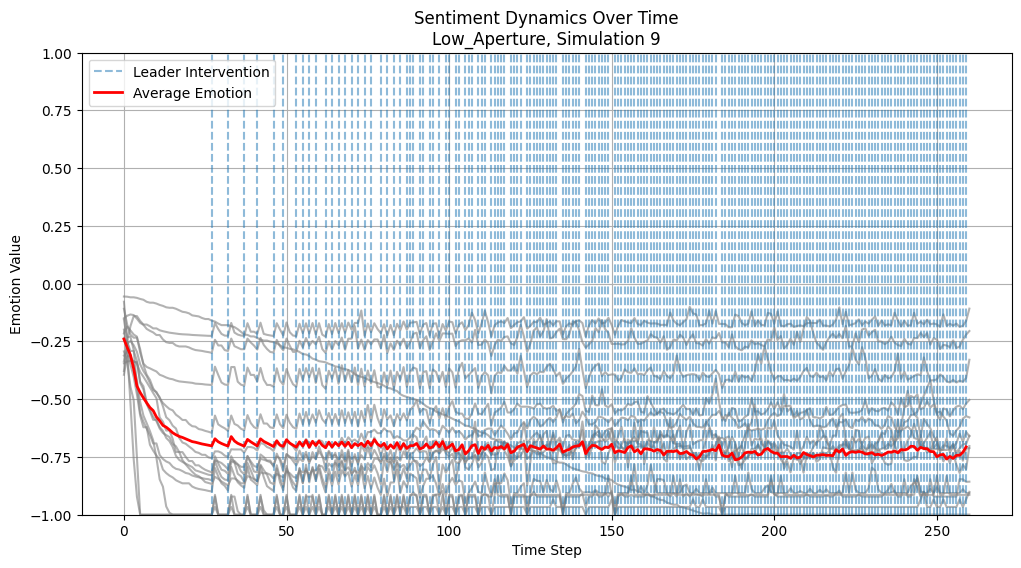

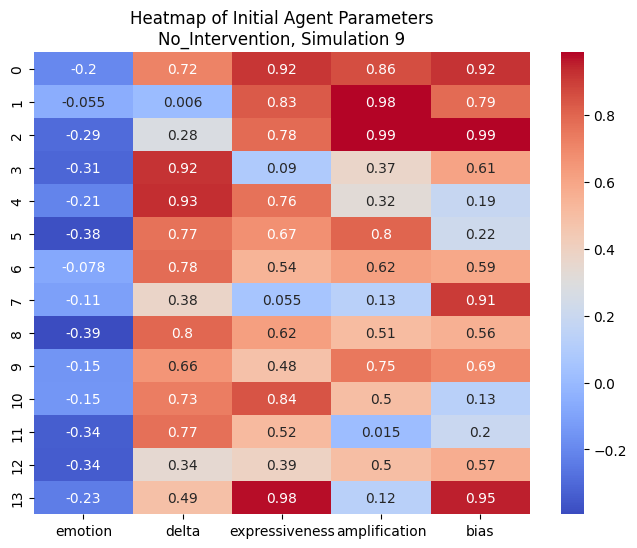

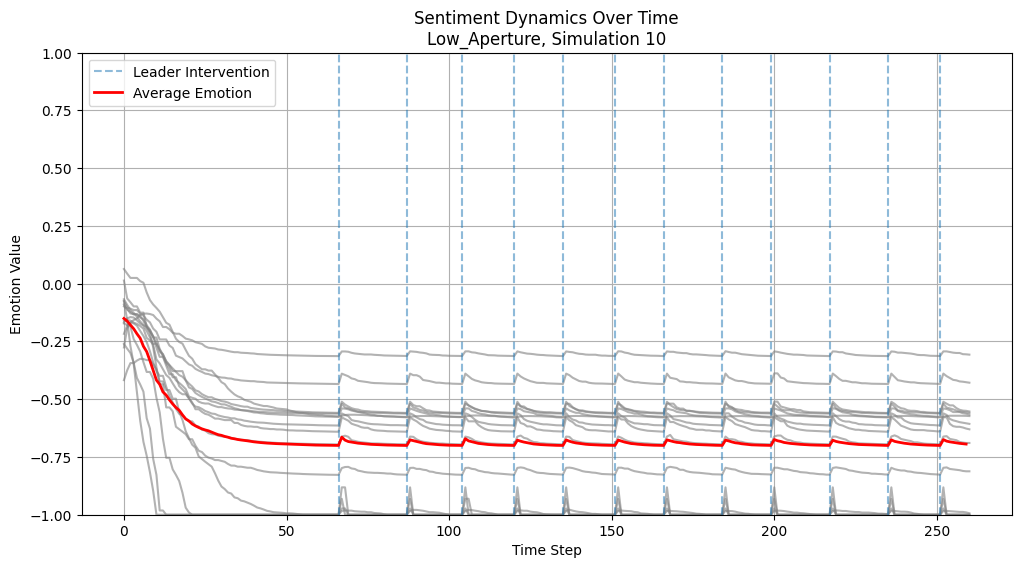

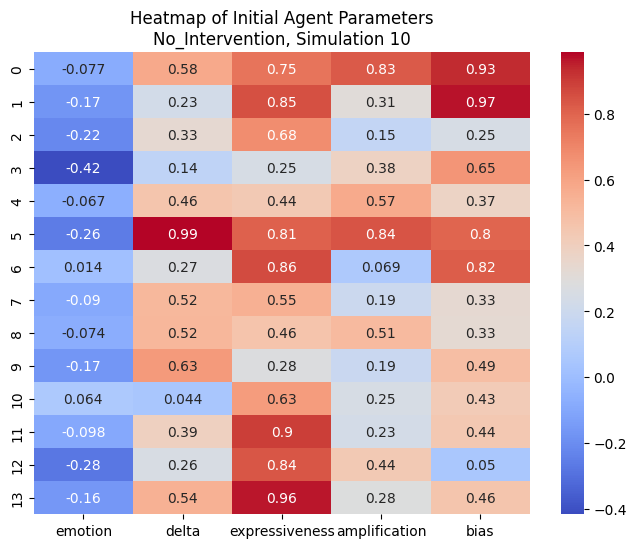

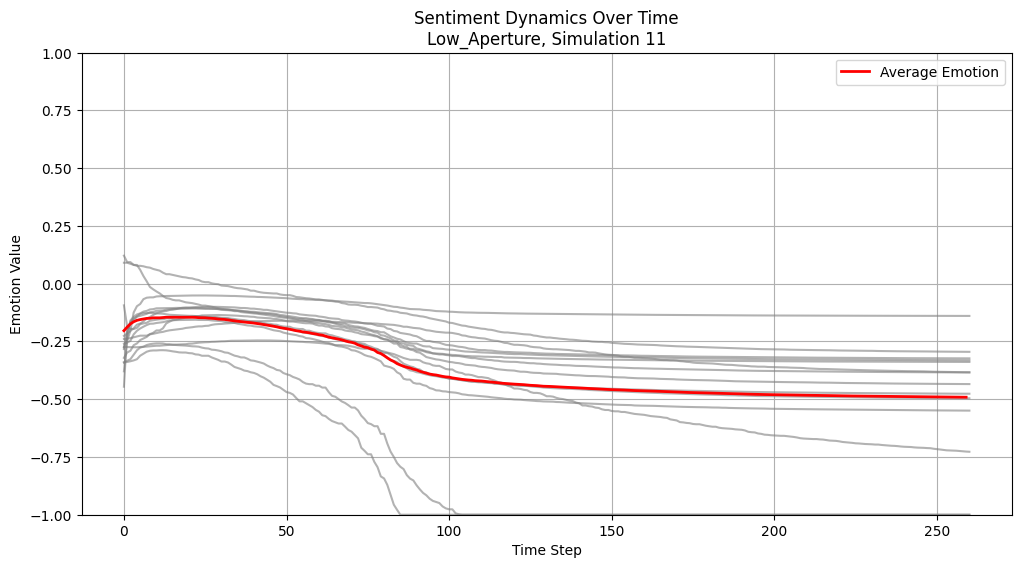

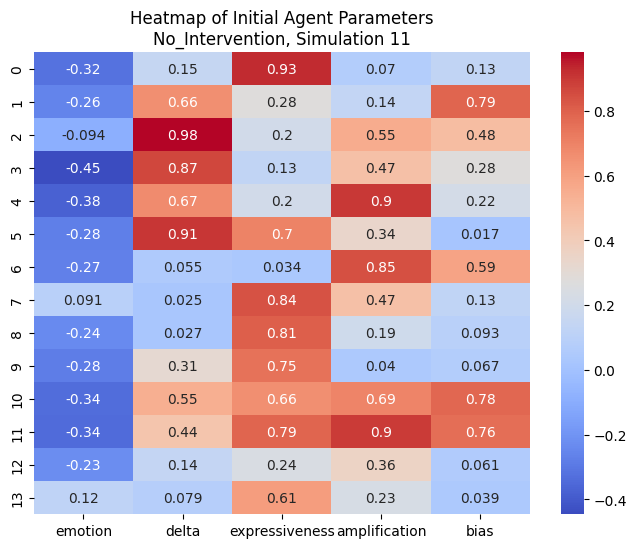

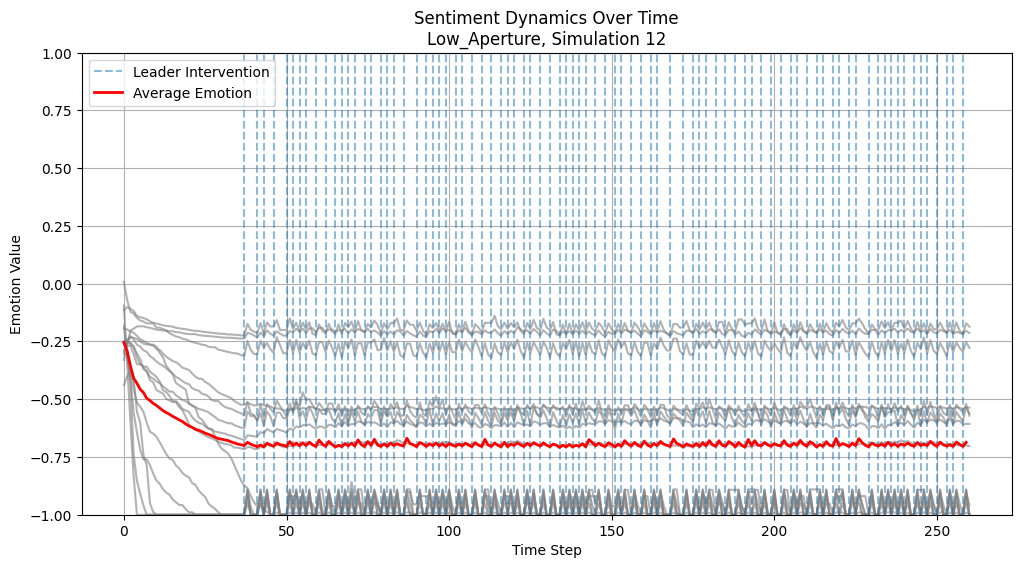

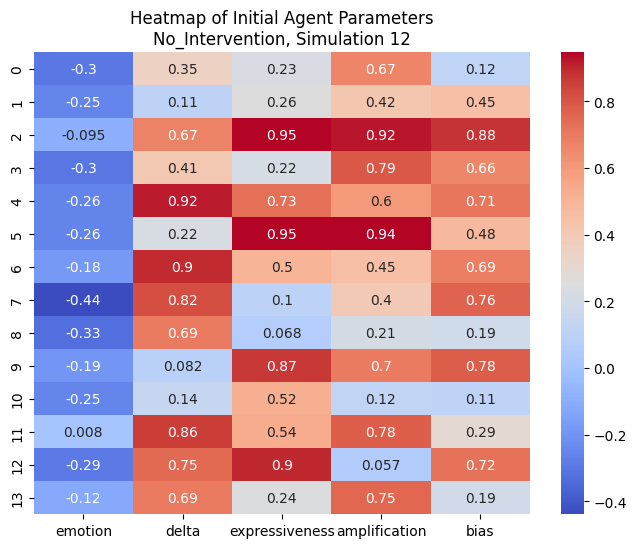

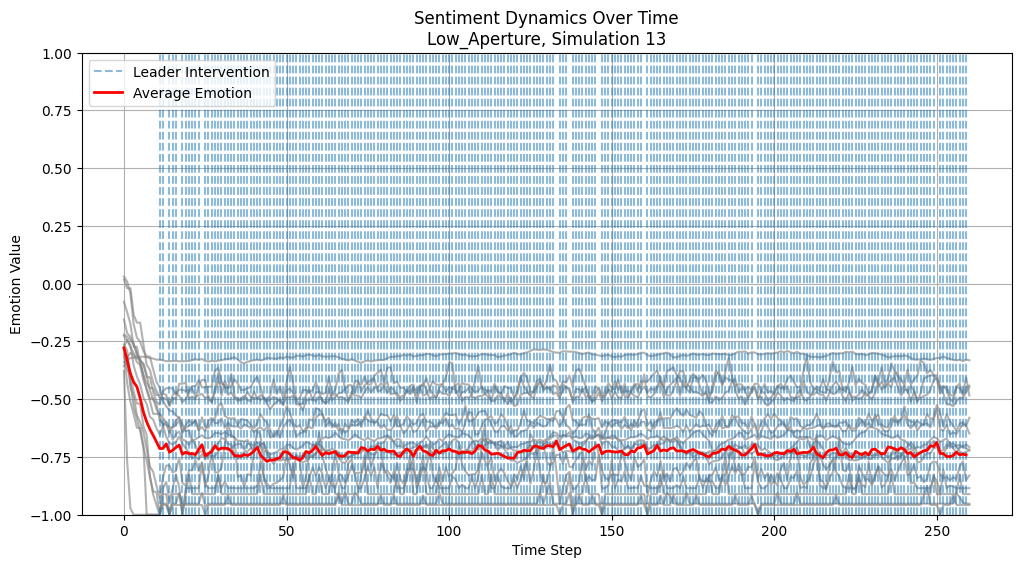

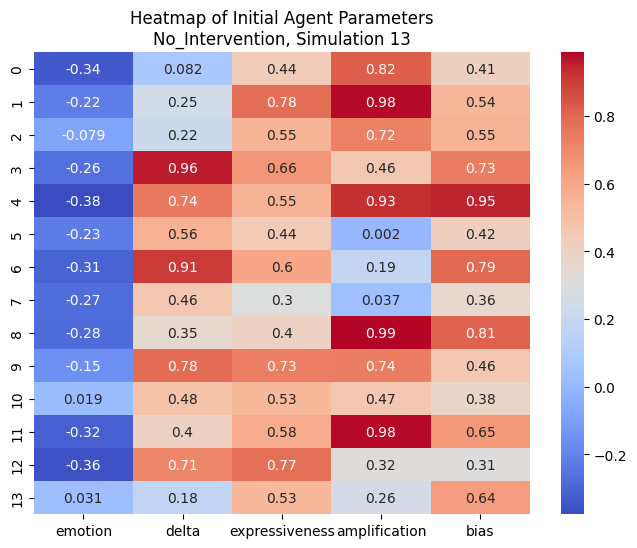

In [97]:
# Emotion evolution graphs with heatmaps of initial conditions
from IPython.display import display

for i, (img, hm) in enumerate(zip(all_results.sentiment_graphs, heatmaps)):
    display(img)
    display(hm)